In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax.tree_util import tree_map_with_path
jax.config.update('jax_platform_name', 'cpu')
import pickle as pkl

import os
from utils import *

def get_ckpt_paths(path):
    files = [f for f in os.listdir(path)]
    files = sorted(files, key = lambda f : int(f.split(".")[0]))

    return [(int(f.split(".")[0]),path + f) for f in files]

def load_ckpt(path):
    with open(path, "rb") as f:
        ckpt = pkl.load(f)

    return ckpt

def plot_stats(path, key, label, ax = None):
    x = []
    y = []
    for i,p in get_ckpt_paths(path):
        ckpt = load_ckpt(p)
        x.append(i)
        y.append(jnp.mean(ckpt[key]))
    if ax == None:
        plt.plot(x,y,label=label)
    else:
        ax.plot(x,y,label=label)


def plot_xhyperparams_yacc(paths, hyperparams, key, label, ax=None):
    x = []
    y = []
    for path,hparam in zip(paths,hyperparams):
        max_agg = []
        for _,p in get_ckpt_paths(path):
            ckpt = load_ckpt(p)
            max_agg.append(jnp.mean(ckpt[key]))

        x.append(hparam)
        y.append(np.max(max_agg))
    if ax == None:
        plt.plot(x,y,label=label)
    else:
        ax.plot(x,y,label=label)

def make_label(s):
    s = keystr(s)
    s = s.split("'][")[0].split("['")[1]
    return s

def plot_channel_norms(path, get_weights_fn, plot_fns, axs):
    timestamps = []
    stats = []

    assert len(plot_fns) == len(axs)

    cond_fn = lambda s,_ : "conv" in keystr(s).lower() and "kernel" in keystr(s).lower()
    def true_fn(_,x):
        return {"c_norm" : c_norm(x), "c_mean" : c_mean(x), "b_mean" : b_mean(x), "g_norm" : g_norm(x), "g_mean" : g_mean(x)}
    false_fn = lambda _,__ : None

    for i,p in get_ckpt_paths(path):
        ckpt = load_ckpt(p)
        timestamps.append(i)
        w = get_weights_fn(ckpt)

        stats.append(conditional_tree_map((w,),cond_fn,true_fn,false_fn))

    w = tree_map_with_path(lambda _,*x : jnp.stack(x,axis=1) if x is not None else None,*stats)

    for plot_fn,ax in zip(plot_fns,axs):
        jax.tree_util.tree_map_with_path(lambda s,x : ax.plot(timestamps,plot_fn(s,x),label=make_label(s)) if plot_fn(s,x) is not None else None, w)

       

2024-11-28 11:44:49.804548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 11:44:49.813990: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 11:44:49.816786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 11:44:50.262583: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
fig,axs = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(10,5)
mean_c_norm_fn = lambda s,x : jnp.mean(jnp.mean(x,axis=-1),axis=0) if "c_norm" in keystr(s).lower() else None
var_c_norm_fn = lambda s,x : jnp.mean(jnp.var(x,axis=-1),axis=0) if "c_norm" in keystr(s).lower() else None
plot_channel_norms("./exps_sgdm/wd0.005/states/",lambda ckpt : ckpt[0],[mean_c_norm_fn,var_c_norm_fn],axs)

axs[0].set_title(r'Sgdm with Weight Decay | Mean of channel norms')
axs[0].set_xlabel("training step")

axs[1].set_title(r'Sgdm with Weight Decay | Variance of channel norms')
axs[1].set_xlabel("training step")

_, labels = axs[1].get_legend_handles_labels()
fig.legend(labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,-0.05), bbox_transform=fig.transFigure)
fig.tight_layout()
plt.savefig("./images/wd0.005_c_norms_mean_and_var.png",dpi=300,bbox_inches="tight")
plt.close()

In [52]:
fig,axs = plt.subplots(nrows=2,ncols=4)
fig.set_size_inches(15,10)
mean_c_norm_fn = lambda s,x : jnp.mean(jnp.mean(x,axis=-1),axis=0) if "c_norm" in keystr(s).lower() else None
var_c_norm_fn = lambda s,x : jnp.mean(jnp.var(x,axis=-1),axis=0) if "c_norm" in keystr(s).lower() else None
mean_c_mean_fn = lambda s,x : jnp.mean(jnp.mean(x,axis=-1),axis=0) if "c_mean" in keystr(s).lower() else None
var_c_mean_fn = lambda s,x : jnp.mean(jnp.var(x,axis=-1),axis=0) if "c_mean" in keystr(s).lower() else None

plot_channel_norms("./exps_sgdm/no_wd/states/",lambda ckpt : ckpt[0],[mean_c_norm_fn,var_c_norm_fn,mean_c_mean_fn,var_c_mean_fn],axs[0])
plot_channel_norms("./exps_adam/no_wd/states/",lambda ckpt : ckpt[0],[mean_c_norm_fn,var_c_norm_fn,mean_c_mean_fn,var_c_mean_fn],axs[1])


axs[0,0].set_title(r'Sgdm | Mean of channel norms'),axs[0,0].set_xlabel("training step")
axs[0,1].set_title(r'Sgdm | Variance of channel norms'),axs[0,1].set_xlabel("training step")
axs[0,2].set_title(r'Sgdm | Mean of channel means'),axs[0,2].set_xlabel("training step")
axs[0,3].set_title(r'Sgdm | Variance of channel means'),axs[0,3].set_xlabel("training step")

axs[1,0].set_title(r'Adam | Mean of channel norms'),axs[1,0].set_xlabel("training step")
axs[1,1].set_title(r'Adam | Variance of channel norms'),axs[1,1].set_xlabel("training step")
axs[1,2].set_title(r'Adam | Mean of channel means'),axs[1,2].set_xlabel("training step")
axs[1,3].set_title(r'Adam | Variance of channel means'),axs[1,3].set_xlabel("training step")

_, labels = axs[1,3].get_legend_handles_labels()
fig.legend(labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,-0.025), bbox_transform=fig.transFigure)
fig.tight_layout()
plt.savefig("./images/no_wd_sgdm_vs_adam_c_norms_c_means.png",dpi=300,bbox_inches="tight")
plt.close()

In [60]:
plot_stats("./exps_sgdm/wd0.005/test_stats/","acc","WD")
plot_stats("./exps_sgdm/no_wd/test_stats/","acc","no WD")
plot_stats("./exps_sgdm/cd_1_1/test_stats/","acc","CWND")

plt.legend()
plt.xlabel("training step")
plt.ylabel("validation acc")
ax = plt.gca()
ax.set_ylim(0.65,0.85)
plt.savefig("images/sgdm_acc_compare_wd_nowd_cwnd.png",dpi=300)
plt.close()

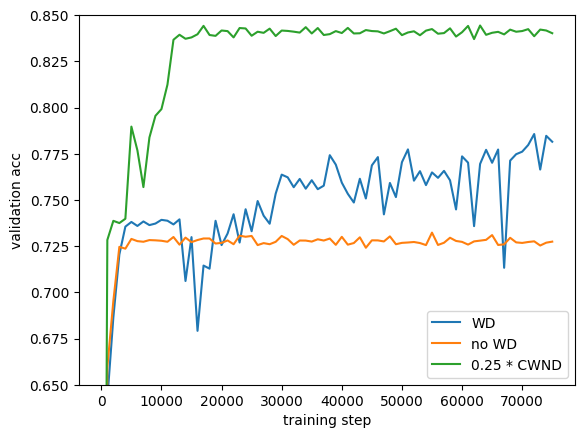

In [62]:
plot_stats("./exps_sgdm/wd0.005/test_stats/","acc","WD")
plot_stats("./exps_sgdm/no_wd/test_stats/","acc","no WD")
plot_stats("./exps_sgdm/cd_0.25_1/test_stats/","acc","0.25 * CWND")

plt.legend()
plt.xlabel("training step")
plt.ylabel("validation acc")
ax = plt.gca()
ax.set_ylim(0.65,0.85)
plt.savefig("images/sgdm_acc_compare_wd_nowd_0.25cwnd.png",dpi=300)

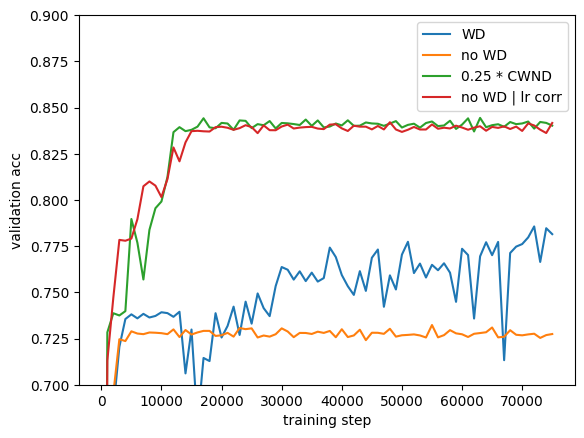

In [67]:
plot_stats("./exps_sgdm/wd0.005/test_stats/","acc","WD")
plot_stats("./exps_sgdm/no_wd/test_stats/","acc","no WD")
plot_stats("./exps_sgdm/cd_0.25_1/test_stats/","acc","0.25 * CWND")
plot_stats("./exps_sgdm/no_wd_lr_corr/test_stats/","acc","no WD | lr corr")

plt.legend()
plt.xlabel("training step")
plt.ylabel("validation acc")
ax = plt.gca()
ax.set_ylim(0.7,0.9)
plt.savefig("images/sgdm_acc_compare_wd_nowd_0.25cwnd_nowdlrcorr.png",dpi=300)

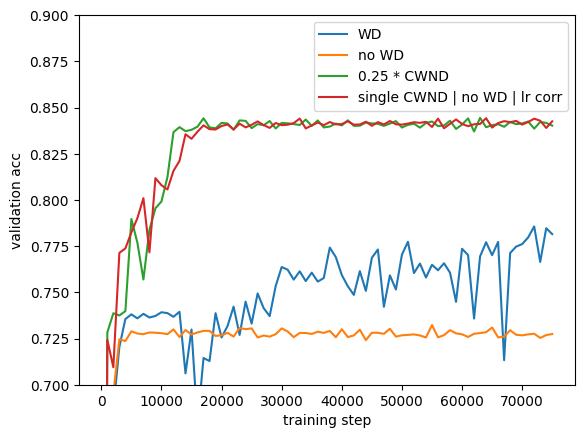

In [66]:
plot_stats("./exps_sgdm/wd0.005/test_stats/","acc","WD")
plot_stats("./exps_sgdm/no_wd/test_stats/","acc","no WD")
plot_stats("./exps_sgdm/cd_0.25_1/test_stats/","acc","0.25 * CWND")
plot_stats("./exps_sgdm/single_cd_no_wd_lr_corr/test_stats/","acc","single CWND | no WD | lr corr")

plt.legend()
plt.xlabel("training step")
plt.ylabel("validation acc")
ax = plt.gca()
ax.set_ylim(0.7,0.9)
plt.savefig("images/sgdm_acc_compare_wd_nowd_0.25cwnd_singlecdnowdlrcorr.png",dpi=300)

(0.7, 0.9)

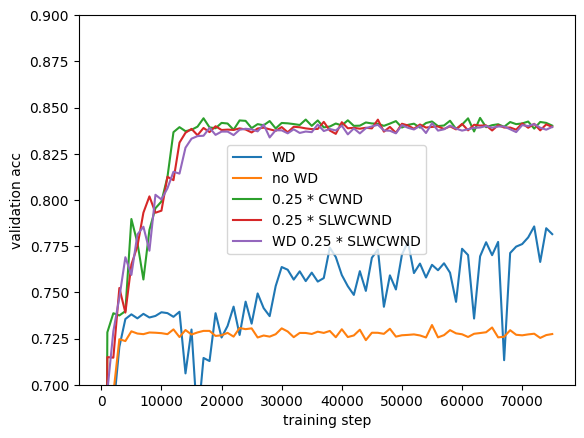

In [2]:
plot_stats("./exps_sgdm/wd0.005/test_stats/","acc","WD")
plot_stats("./exps_sgdm/no_wd/test_stats/","acc","no WD")
plot_stats("./exps_sgdm/cd_0.25_1/test_stats/","acc","0.25 * CWND")
plot_stats("./exps_sgdm/slw_cd_0.25_1/test_stats/","acc","0.25 * SLWCWND")
plot_stats("./exps_sgdm/wd-0.005_slw_cd_0.25_1/test_stats/","acc","WD 0.25 * SLWCWND")
plt.legend()
plt.xlabel("training step")
plt.ylabel("validation acc")
ax = plt.gca()
ax.set_ylim(0.7,0.9)
#plt.savefig("images/sgdm_acc_compare_wd_nowd_0.25cwnd_singlecdnowdlrcorr.png",dpi=300)

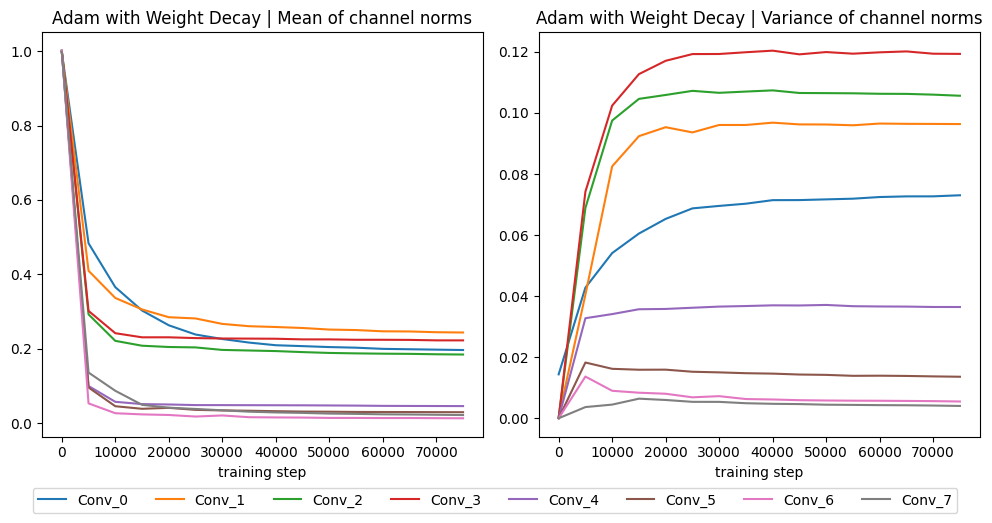

In [17]:
fig,axs = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(10,5)
mean_c_norm_fn = lambda s,x : jnp.mean(jnp.mean(x,axis=-1),axis=0) if "c_norm" in keystr(s).lower() else None
var_c_norm_fn = lambda s,x : jnp.mean(jnp.var(x,axis=-1),axis=0) if "c_norm" in keystr(s).lower() else None
plot_channel_norms("./exps_adam/wd0.005/states/",lambda ckpt : ckpt[0],[mean_c_norm_fn,var_c_norm_fn],axs)

axs[0].set_title(r'Adam with Weight Decay | Mean of channel norms')
axs[0].set_xlabel("training step")

axs[1].set_title(r'Adam with Weight Decay | Variance of channel norms')
axs[1].set_xlabel("training step")

_, labels = axs[1].get_legend_handles_labels()
fig.legend(labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,-0.05), bbox_transform=fig.transFigure)
fig.tight_layout()


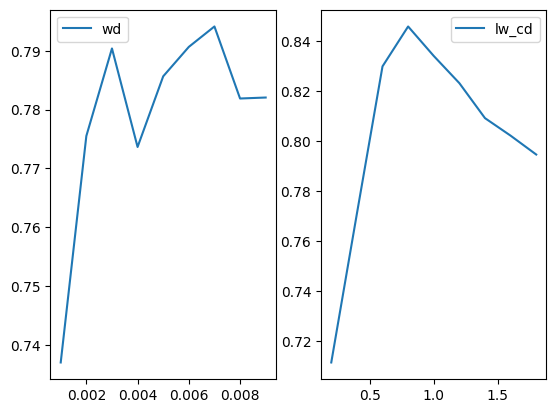

In [69]:
fig,ax = plt.subplots(nrows=1,ncols=2)

paths = ["./exps_sgdm/wd0.001/test_stats/",
         "./exps_sgdm/wd0.002/test_stats/",
         "./exps_sgdm/wd0.003/test_stats/",
         "./exps_sgdm/wd0.004/test_stats/",
         "./exps_sgdm/wd0.005/test_stats/",
         "./exps_sgdm/wd0.006/test_stats/",
         "./exps_sgdm/wd0.007/test_stats/",
         "./exps_sgdm/wd0.008/test_stats/",
         "./exps_sgdm/wd0.009/test_stats/"]

hyperparams = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009]

plot_xhyperparams_yacc(paths,hyperparams,"acc","wd",ax[0])
ax[0].legend()

paths = ["./exps_sgdm/lw_cd_0.2_1/test_stats/",
         "./exps_sgdm/lw_cd_0.4_1/test_stats/",
         "./exps_sgdm/lw_cd_0.6_1/test_stats/",
         "./exps_sgdm/lw_cd_0.8_1/test_stats/",
         "./exps_sgdm/lw_cd_1_1/test_stats/",
         "./exps_sgdm/lw_cd_1.2_1/test_stats/",
         "./exps_sgdm/lw_cd_1.4_1/test_stats/",
         "./exps_sgdm/lw_cd_1.6_1/test_stats/",
         "./exps_sgdm/lw_cd_1.8_1/test_stats/",]

hyperparams = [0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8]

plot_xhyperparams_yacc(paths,hyperparams,"acc","lw_cd",ax[1])
ax[1].legend()

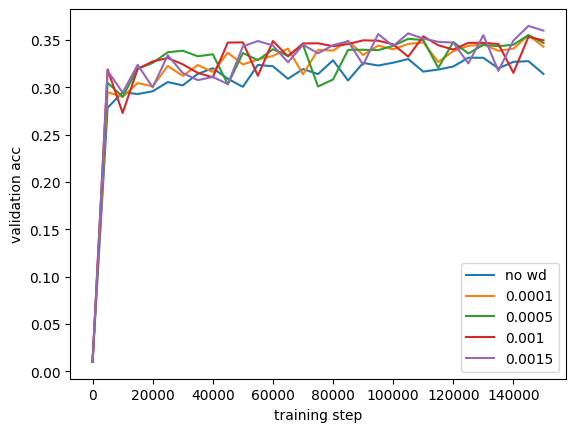

In [11]:
stats = "test_stats"
lr = "0.0001"
plot_stats("./exps_adam/no_wd_lr" + lr +"/"+stats+"/","acc","no wd")
plot_stats("./exps_adam/wd0.0001_lr" + lr +"/"+stats+"/","acc","0.0001")
plot_stats("./exps_adam/wd0.0005_lr" + lr +"/"+stats+"/","acc","0.0005")
plot_stats("./exps_adam/wd0.001_lr" + lr +"/"+stats+"/","acc","0.001")
plot_stats("./exps_adam/wd0.0015_lr" + lr +"/"+stats+"/","acc","0.0015")
#plot_stats("./exps_adam/wd0.0005_lr0.0001/"+stats+"/","acc","wd0.0005_lr0.0001")
#plot_stats("./exps_adam/cd_1_1/"+stats+"/","acc","CWND")
#plot_stats("./exps_adam/cd_0.25_1/"+stats+"/","acc","0.25 * CWND")

plt.legend()
plt.xlabel("training step")
plt.ylabel("validation acc")
ax = plt.gca()
#ax.set_ylim(0.4,0.5)